In [15]:
# Data cleaning and preprocessing

!pip install pandas numpy scikit-learn nltk matplotlib seaborn

import pandas as pd

# load data
data = pd.read_csv("combined_worldnews_data.csv")

print(data.head())

import re
import nltk
from nltk.corpus import stopwords
import pandas as pd

nltk.download('stopwords')

# data cleaning
def clean_text(text):
    text = re.sub(r'\W+', ' ', text) 
    text = text.lower()  
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])  
    return text

data['Text'] = data.apply(lambda row: row['Title'] if pd.isna(row['Text']) else row['Text'], axis=1)

data['Number of Comments'] = data['Number of Comments'].replace('Comment', 0)

data['Number of Comments'] = data['Number of Comments'].astype(int)


data['Cleaned_Title'] = data['Title'].apply(clean_text)
data['Cleaned_Text'] = data['Text'].apply(clean_text)

print(data[['Cleaned_Title', 'Cleaned_Text']].head())



                                               Title Text  \
0  ICC prosecutor warns Israel over preventing ai...  NaN   
1  Luxury hotels in place of bombed homes: the co...  NaN   
2  Your prisoner is only a baby: a letter to the ...  NaN   
3  Germany's Scholz says his country willing to i...  NaN   
4  Australian producers to keep prosecco, feta an...  NaN   

             Timestamp                Author  Upvotes Number of Comments  \
0  2023-10-30T00:54:31            Saltedline        4                  0   
1  2023-10-30T00:53:38    ElSuprimoGrande767        7                  0   
2  2023-10-30T00:43:54    ElSuprimoGrande767        5                  0   
3  2023-10-30T00:41:26             donutloop        2                  0   
4  2023-10-30T00:26:50  nosotros_road_sodium        7                  1   

                                                 URL  
0  https://www.scmp.com/news/world/middle-east/ar...  
1  https://www.ynetnews.com/magazine/article/s1n9...  
2  https://

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jianbai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                       Cleaned_Title  \
0  icc prosecutor warns israel preventing aid get...   
1  luxury hotels place bombed homes countries hos...   
2                        prisoner baby letter jailer   
3  germany scholz says country willing invest nig...   
4  australian producers keep prosecco feta parmes...   

                                        Cleaned_Text  
0  icc prosecutor warns israel preventing aid get...  
1  luxury hotels place bombed homes countries hos...  
2                        prisoner baby letter jailer  
3  germany scholz says country willing invest nig...  
4  australian producers keep prosecco feta parmes...  


In [16]:
# featuring


from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)

title_bow = vectorizer.fit_transform(data['Cleaned_Title'])
text_bow = vectorizer.fit_transform(data['Cleaned_Text'])

print(title_bow.shape, text_bow.shape)


(5001, 285) (5001, 1000)


In [17]:

from sklearn.model_selection import train_test_split

X = text_bow  
y = data['Upvotes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# prediction
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 48892.46782347417


In [19]:
# Model optimization

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# random forest
rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")


Fitting 3 folds for each of 18 candidates, totalling 54 fits


D:\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
27 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
14 fits failed with the following error:
Traceback (most recent call last):
  File "D:\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "D:\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "D:\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_pa

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}


In [20]:
# Model evaluation

best_rf = RandomForestRegressor(**best_params)
best_rf.fit(X_train, y_train)

best_predictions = best_rf.predict(X_test)
best_mse = mean_squared_error(y_test, best_predictions)
print(f"Improved Mean Squared Error: {best_mse}")


Improved Mean Squared Error: 20911.78147576334


D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


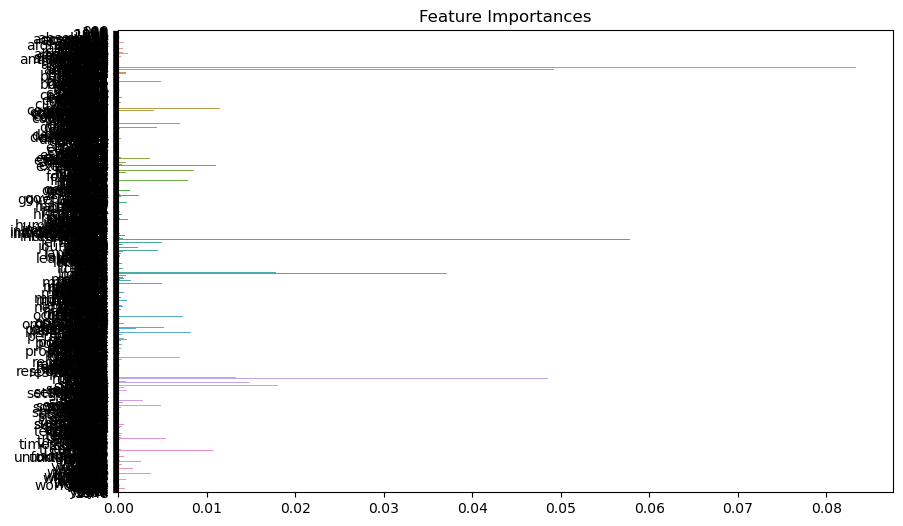

In [21]:
# Feature importance
feature_importances = best_rf.feature_importances_

# visualization
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances, y=vectorizer.get_feature_names_out())
plt.title('Feature Importances')
plt.show()


D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


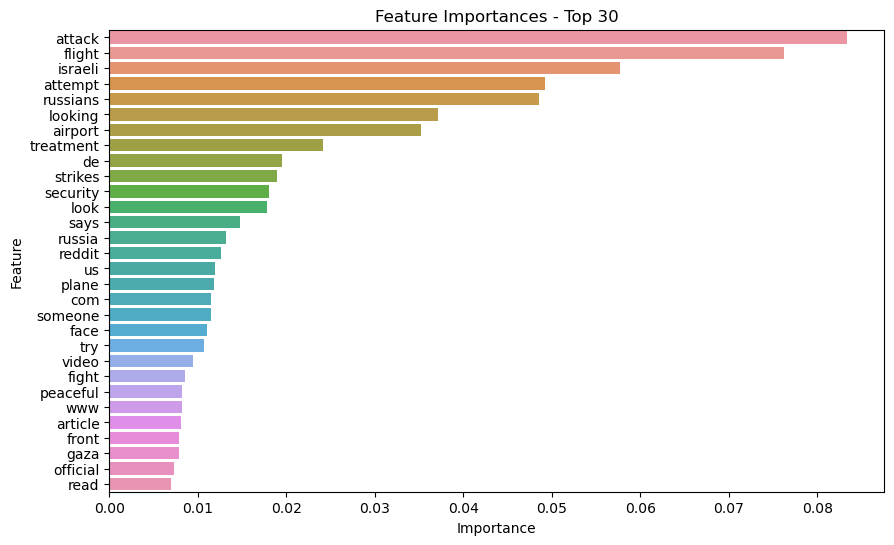

In [22]:
# feature importances
feature_importances = best_rf.feature_importances_

feature_names = vectorizer.get_feature_names_out()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(30)

# top 30 feature importance
plt.figure(figsize=(10,6))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'])
plt.title('Feature Importances - Top 30')
plt.show()

D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


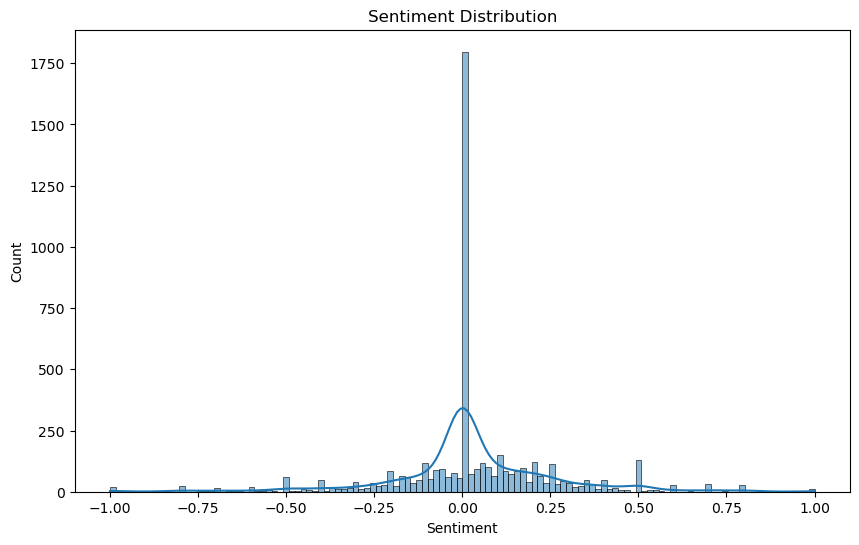

In [24]:
# Sentiment analysis
!pip install textblob
from textblob import TextBlob

data['Sentiment'] = data['Cleaned_Text'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10,6))
sns.histplot(data['Sentiment'], kde=True)
plt.title('Sentiment Distribution')
plt.show()


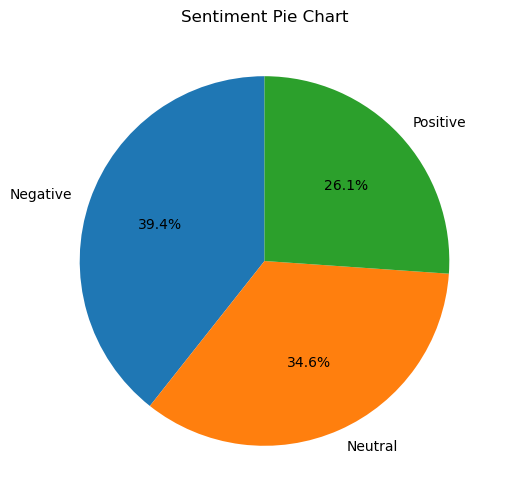

D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


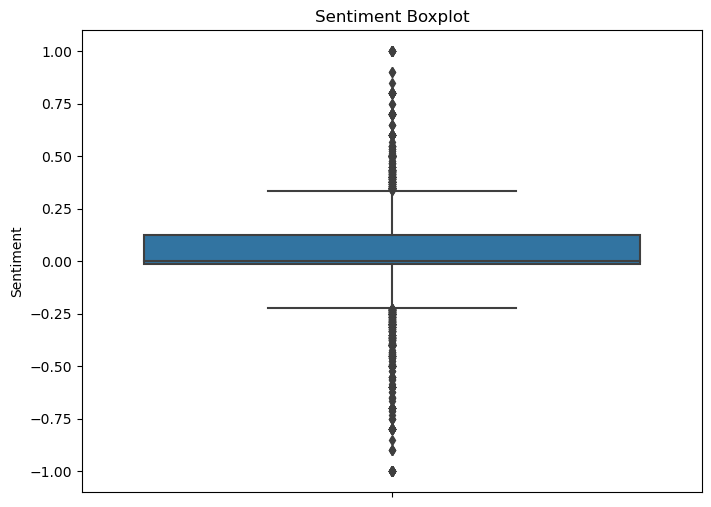

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Categorized as positive, negative and neutral based on emotional polarity
data['Sentiment_Label'] = data['Sentiment'].apply(lambda x: 'Negative' if x > 0 else ('Positive' if x < 0 else 'Neutral'))

# pie plot
sentiment_counts = data['Sentiment_Label'].value_counts()
plt.figure(figsize=(8, 6))
sentiment_counts.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Pie Chart')
plt.ylabel('')
plt.show()

# box plot
plt.figure(figsize=(8, 6))
sns.boxplot(y=data['Sentiment'])
plt.title('Sentiment Boxplot')
plt.show()


            Upvotes
count   5001.000000
mean      28.280144
std      294.952564
min     -442.000000
25%        1.000000
50%        2.000000
75%       10.000000
max    16889.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Title               5001 non-null   object
 1   Text                4962 non-null   object
 2   Timestamp           5001 non-null   object
 3   Author              4744 non-null   object
 4   Upvotes             5001 non-null   int64 
 5   Number of Comments  5001 non-null   object
 6   URL                 5001 non-null   object
dtypes: int64(1), object(6)
memory usage: 273.6+ KB
None


D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


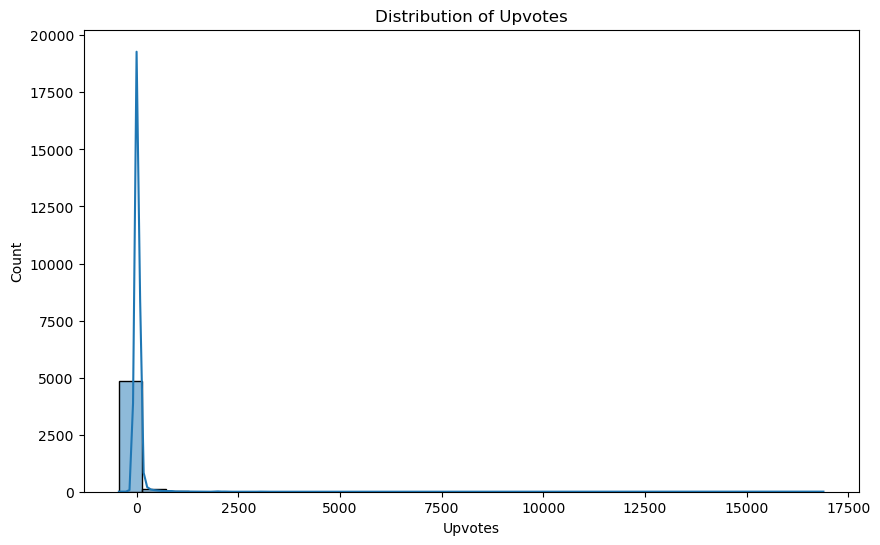

In [28]:
# Data Loading and Exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv("combined_worldnews_data.csv")

# Basic exploration
print(df.describe())
print(df.info())

# Distribution of upvotes
plt.figure(figsize=(10,6))
sns.histplot(df['Upvotes'], bins=30, kde=True)
plt.title('Distribution of Upvotes')
plt.show()


In [29]:
# Data Cleaning for NLP

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Function to clean text data
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # remove non-alphabetic characters
    text = text.lower()
    text = text.split()
    text = [WordNetLemmatizer().lemmatize(word) for word in text if word not in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

df['Text'] = df.apply(lambda row: row['Title'] if pd.isna(row['Text']) else row['Text'], axis=1)

# Apply function to clean the Text column
df['Cleaned_Text'] = df['Text'].apply(clean_text)

    support  itemsets
0  0.144571   (hamas)
1  0.157968  (israel)
2  0.112777    (like)
3  0.135173  (people)


D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


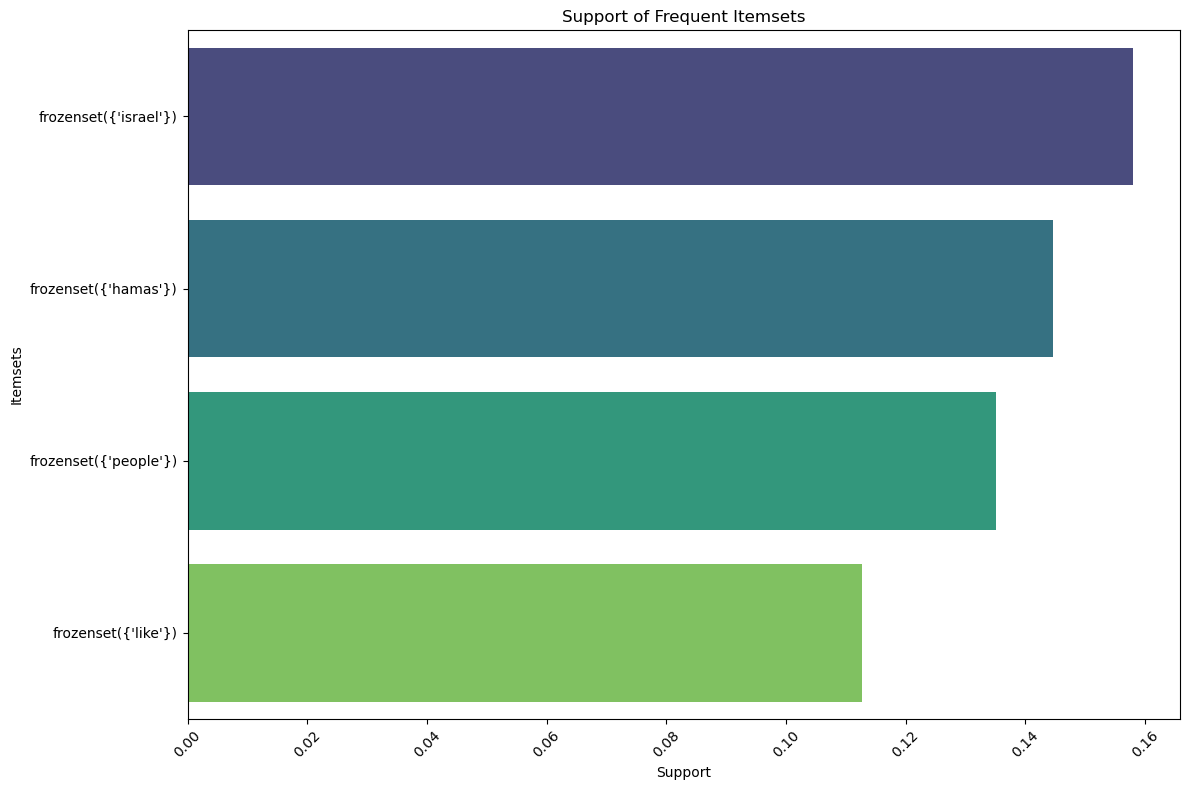

In [30]:
# Frequent Pattern Mining

#!pip install mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori


# Example of creating transactions (This is just a basic example. You'll need to adjust based on your specific use case)
transactions = df['Cleaned_Text'].apply(lambda x: x.split())

# Encoding transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Frequent itemsets
frequent_itemsets = apriori(df_encoded, min_support=0.1, use_colnames=True)
print(frequent_itemsets)



# visualize
import matplotlib.pyplot as plt
import seaborn as sns


frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(y=frequent_itemsets['itemsets'].astype(str), x=frequent_itemsets['support'], palette='viridis')
plt.title('Support of Frequent Itemsets')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


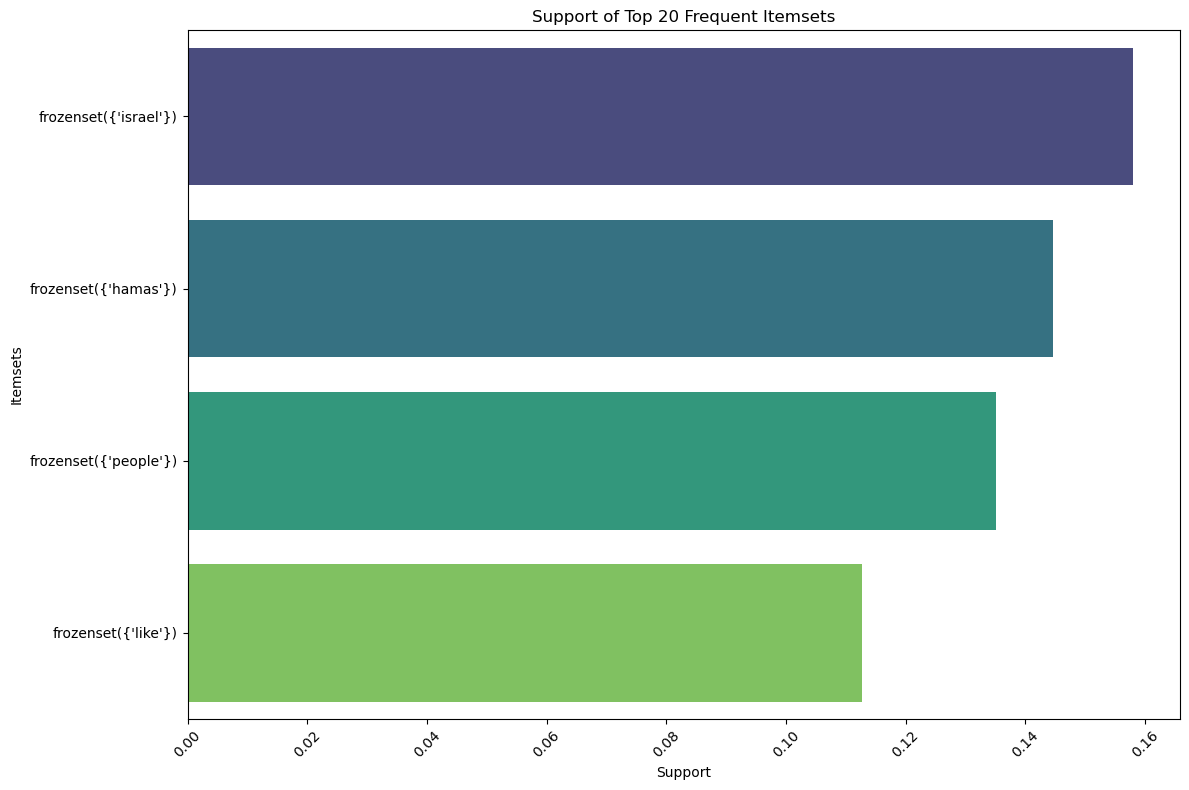

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns


top_20_itemsets = frequent_itemsets.nlargest(20, 'support')


plt.figure(figsize=(12, 8))
sns.barplot(y=top_20_itemsets['itemsets'].astype(str), x=top_20_itemsets['support'], palette='viridis')
plt.title('Support of Top 20 Frequent Itemsets')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
!pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def assign_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

analyzer = SentimentIntensityAnalyzer()
df['Sentiment'] = df['Cleaned_Text'].apply(lambda x: assign_sentiment(analyzer.polarity_scores(x)['compound']))

In [33]:
# Natural Language Processing: Sentiment Analysis with SVM


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Example sentiment analysis

# Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['Cleaned_Text'])
y = df['Sentiment'].apply(lambda x: 1 if x == 'Positive' else 0)

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Classifier
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       688
           1       0.75      0.50      0.60       313

    accuracy                           0.79      1001
   macro avg       0.78      0.71      0.73      1001
weighted avg       0.79      0.79      0.78      1001



In [41]:
import pandas as pd

# Load the provided CSV file
file_path = 'combined_worldnews_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()


,Title,Text,Timestamp,Author,Upvotes,Number of Comments,URL
0,"30 years after illegal takeover, High Court or...",NaN,2023-11-11T21:26:07,loggiews,21,3,https://www.haaretz.com/israel-news/2023-11-09...
1,Comment,As someone incredibly supportive of the plight...,2023-11-11T21:49:38,ksamim,1,Comment,https://www.haaretz.com/israel-news/2023-11-09...
2,Comment,they did that in gaza and look what happened. ...,2023-11-11T21:53:52,tmoppp,1,Comment,https://www.haaretz.com/israel-news/2023-11-09...
3,Comment,I totally understand what you are saying. This...,2023-11-11T21:54:45,ksamim,1,Comment,https://www.haaretz.com/israel-news/2023-11-09...
4,Three newborns die in Gaza’s largest hospital ...,NaN,2023-11-11T21:21:18,loggiews,13,22,https://www.cnn.com/2023/11/11/middleeast/babi...


In [42]:
from textblob import TextBlob
import re

# Function to clean text data
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

titles = data['Title']

# Clean the text in the titles
cleaned_titles = titles.apply(clean_text)

# Perform sentiment analysis using TextBlob
sentiments = cleaned_titles.apply(lambda title: TextBlob(title).sentiment)

# Create a DataFrame for the sentiments
sentiments_df = pd.DataFrame({
    'Title': cleaned_titles,
    'Polarity': [sentiment.polarity for sentiment in sentiments],
    'Subjectivity': [sentiment.subjectivity for sentiment in sentiments]
})

sentiments_df.head()


,Title,Polarity,Subjectivity
0,30 years after illegal takeover high court ord...,-0.17,0.52
1,comment,0.00,0.00
2,comment,0.00,0.00
3,comment,0.00,0.00
4,three newborns die in gazas largest hospital a...,0.00,0.00


In [44]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

# Function for displaying the top words in each topic
def display_topics(model, feature_names, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topics[topic_idx] = top_features
    return topics

# Number of topics
n_topics = 5
# Number of top words to display for each topic
n_top_words = 10

# Creating a document-word matrix using CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_word_matrix = vectorizer.fit_transform(cleaned_titles)

# Applying LDA
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
lda.fit(doc_word_matrix)

# Getting feature names (words) and displaying topics
feature_names = vectorizer.get_feature_names_out()
topics = display_topics(lda, feature_names, n_top_words)

topics


{0: ['gaza',
  'israel',
  'ukraine',
  'war',
  'hostages',
  'russian',
  'calls',
  'death',
  'says',
  'toll'],
 1: ['hamas',
  'gaza',
  'says',
  'israel',
  'news',
  'ukraine',
  'idf',
  'report',
  'hezbollah',
  'attack'],
 2: ['says',
  'china',
  'deal',
  'russian',
  'south',
  'new',
  'iran',
  'pm',
  'opposition',
  'east'],
 3: ['says',
  'gaza',
  'israeli',
  'military',
  'india',
  'hamas',
  'russia',
  'minister',
  'ukrainian',
  'killed'],
 4: ['war',
  'thread',
  'gaza',
  'israel',
  'ukraine',
  'russian',
  'live',
  'rworldnews',
  'invasion',
  'russia']}

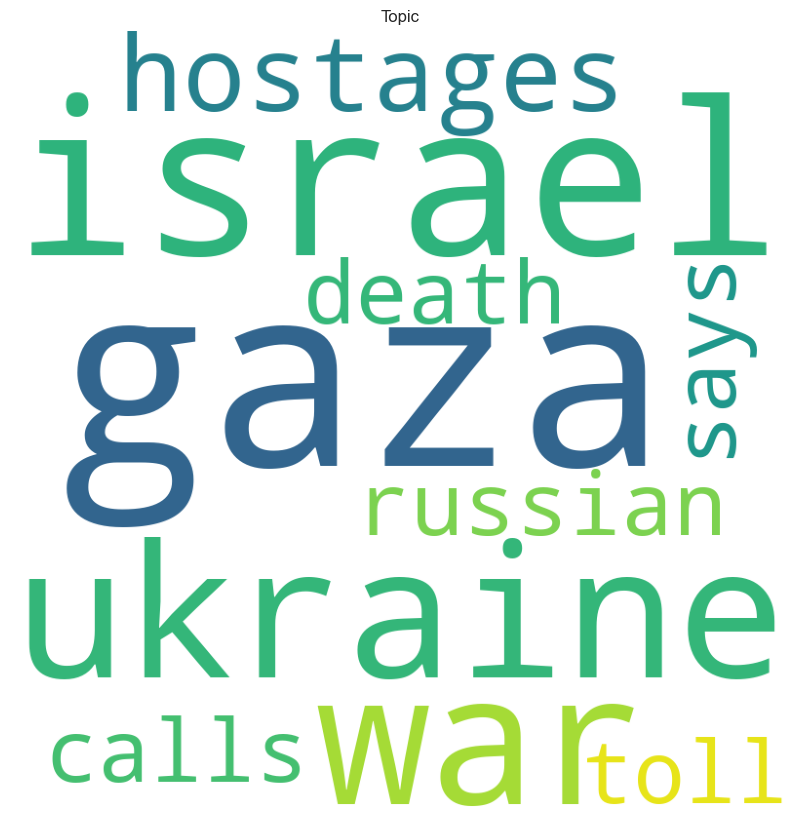

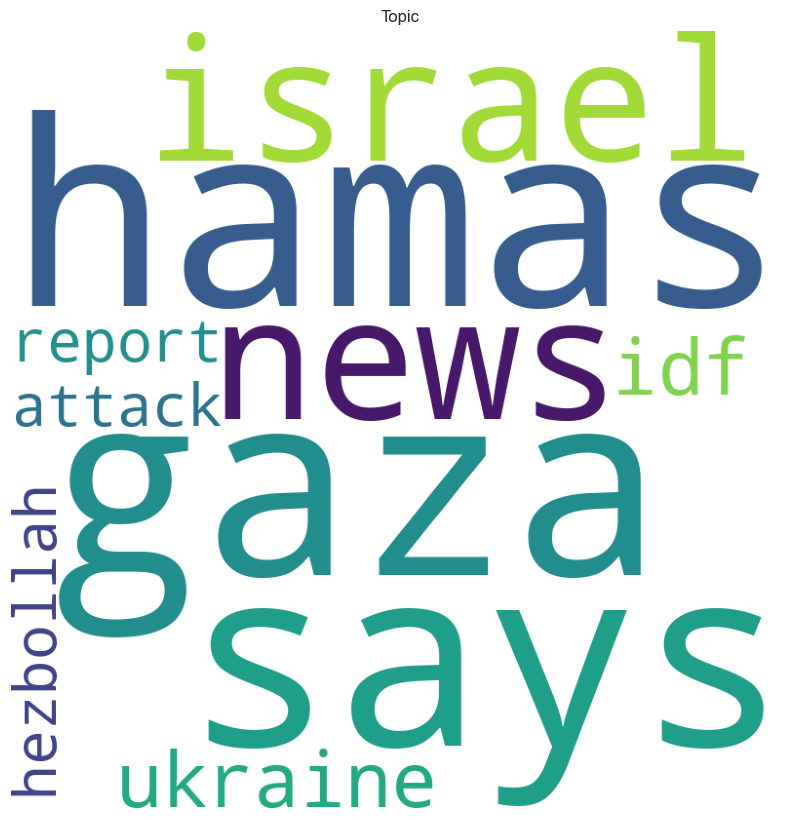

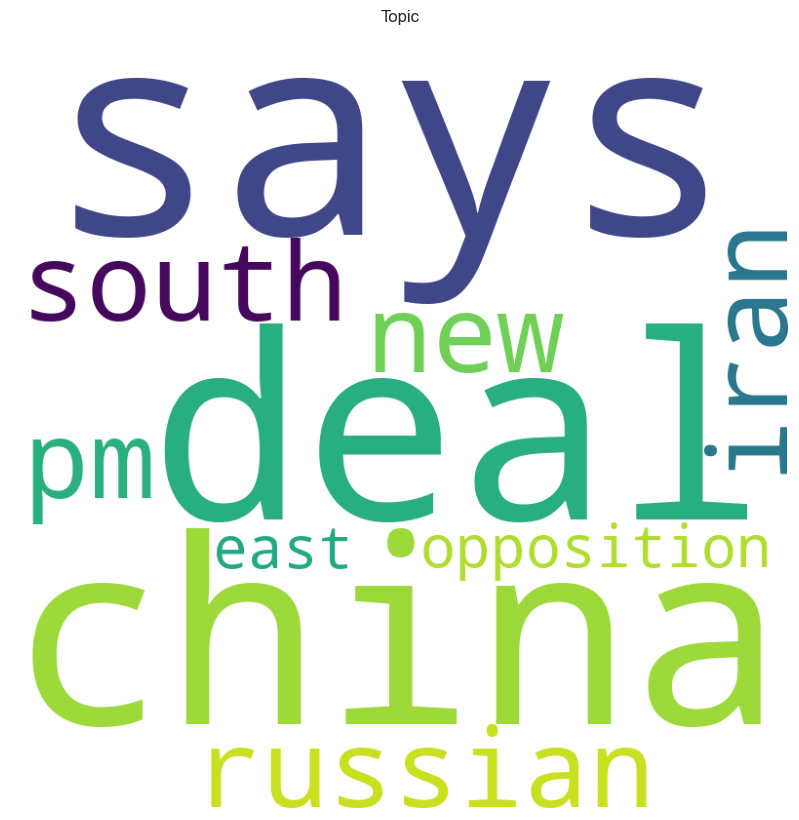

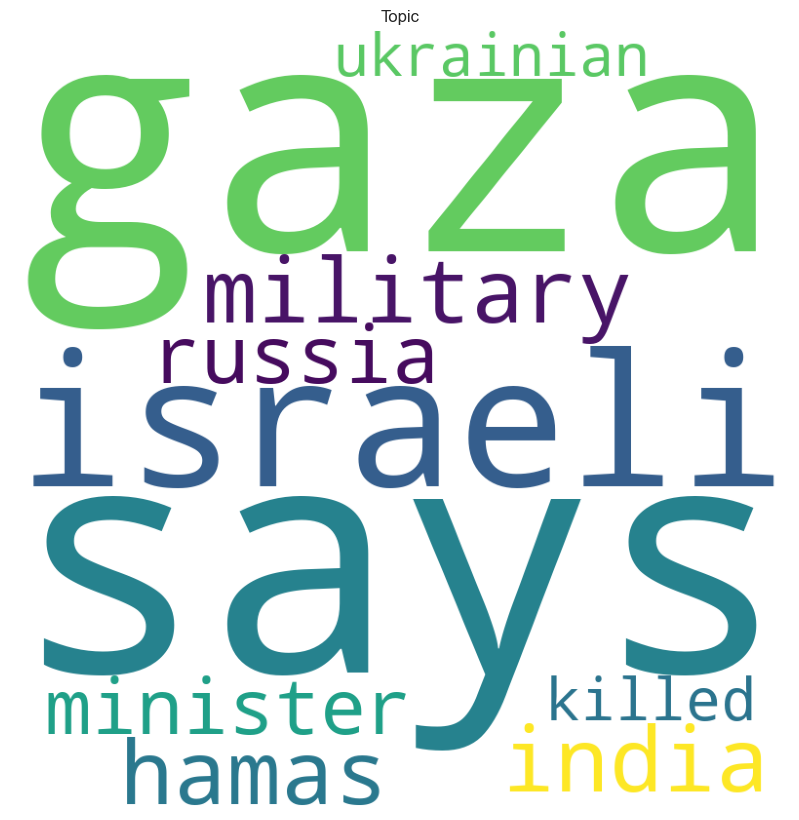

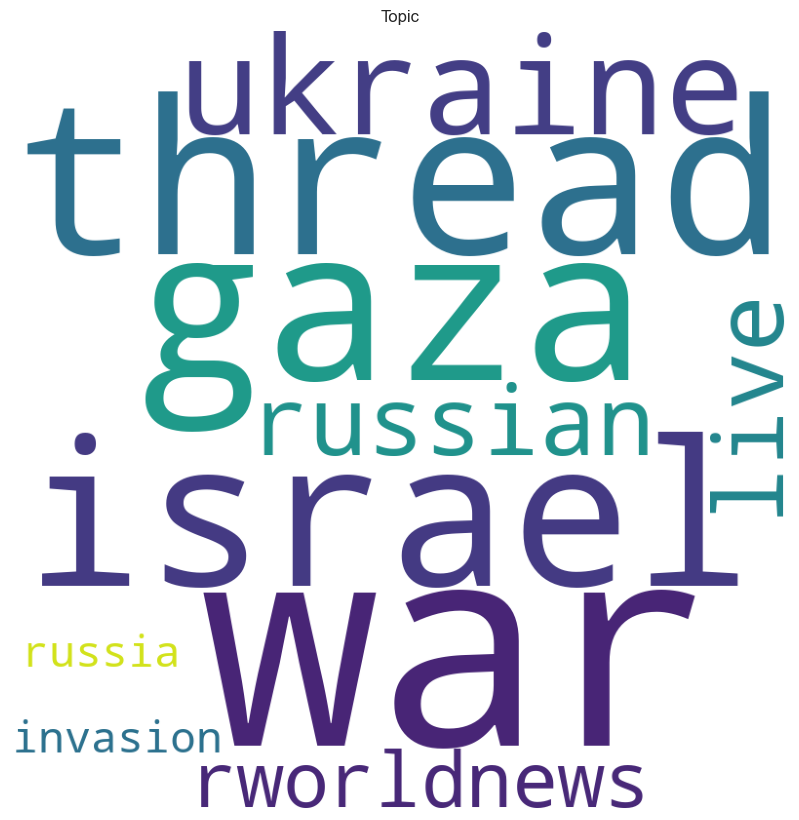

In [50]:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for topic_num, keywords in topics.items():
    text = ' '.join(keywords)
    wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"Topic")
    plt.tight_layout(pad=0)
    plt.show()


D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


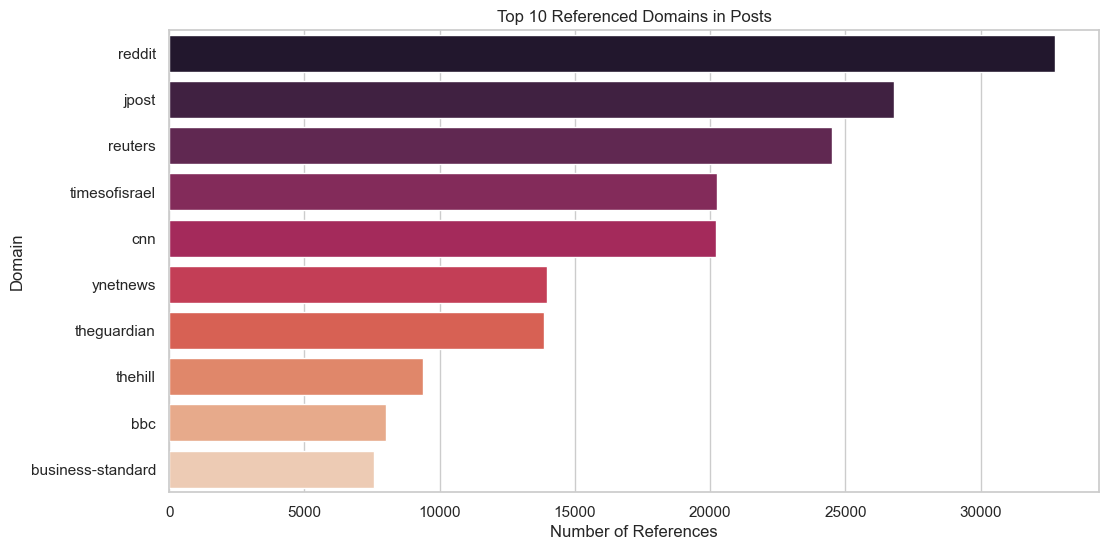

In [49]:
import tldextract
import matplotlib.pyplot as plt
import seaborn as sns

data['Domain'] = data['URL'].apply(lambda url: tldextract.extract(url).domain if pd.notnull(url) else '')

domain_counts = data['Domain'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=domain_counts.values, y=domain_counts.index, palette="rocket")
plt.title('Top 10 Referenced Domains in Posts')
plt.xlabel('Number of References')
plt.ylabel('Domain')
plt.show()
